<a href="https://colab.research.google.com/github/ErmolaevMakcum/ML/blob/master/Bike_Sharing_System.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 0. Описание задачи

Моя задача будет заключаться в классификации погоды по признакам: 

1. *season* - сезон года (1:Весна; 2:Лето; 3:Осень; 4:Зима)
2. *weather* - погода во время аренды велосипеда (1: ясно | мало облаков | переменная облачность; 2: туман | туман + пасмурно | туман + дождь | туман + небольшой облака; 3: легкий снег | легкий дождь + рассеянные облака | легкий дождь + гроза)
3. *temp* - температура (в градусах цельсия)
4. *atemp* - температура (ощущается как)
5. *humidity* - влажность (в %)
6. *windspeed* - скорость ветра (в км/ч)
7. *casual* - количество случайных пользователей
8. *registered* - количество зарегистрированных пользователей
9. *count* - общее количество арендованных велосипедов


In [66]:
import numpy as np              # Массивы (матрицы, векторы, линейная алгебра)
import matplotlib.pyplot as plt # Научная графика
%matplotlib inline 
    # Говорим jupyter'у, чтобы весь графический вывод был в браузере, а не в отдельном окне
import pandas as pd             # Таблицы и временные ряды (dataframe, series)
import seaborn as sns           # Еще больше красивой графики для визуализации данных
import sklearn                  # Алгоритмы машинного обучения

# 1. Чтение данных из файла

In [67]:
data = pd.read_csv('https://raw.githubusercontent.com/ErmolaevMakcum/ML/master/train_bikes.csv')
data

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0000,3,13,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0000,8,32,40
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0000,5,27,32
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0000,3,10,13
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0000,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...
10881,2012-12-19 19:00:00,4,0,1,1,15.58,19.695,50,26.0027,7,329,336
10882,2012-12-19 20:00:00,4,0,1,1,14.76,17.425,57,15.0013,10,231,241
10883,2012-12-19 21:00:00,4,0,1,1,13.94,15.910,61,15.0013,4,164,168
10884,2012-12-19 22:00:00,4,0,1,1,13.94,17.425,61,6.0032,12,117,129


In [68]:
data.columns

Index(['datetime', 'season', 'holiday', 'workingday', 'weather', 'temp',
       'atemp', 'humidity', 'windspeed', 'casual', 'registered', 'count'],
      dtype='object')

Уберём "лишние" столбцы

In [69]:
data = data.drop(data.columns[[0, 2, 3]], axis='columns')
data = data.drop(data[data['weather']==4].index)
data

,season,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,1,1,9.84,14.395,81,0.0000,3,13,16
1,1,1,9.02,13.635,80,0.0000,8,32,40
2,1,1,9.02,13.635,80,0.0000,5,27,32
3,1,1,9.84,14.395,75,0.0000,3,10,13
4,1,1,9.84,14.395,75,0.0000,0,1,1
...,...,...,...,...,...,...,...,...,...
10881,4,1,15.58,19.695,50,26.0027,7,329,336
10882,4,1,14.76,17.425,57,15.0013,10,231,241
10883,4,1,13.94,15.910,61,15.0013,4,164,168
10884,4,1,13.94,17.425,61,6.0032,12,117,129


Боремся с "выбросами":

In [70]:
data['windspeed'].quantile([0.005,.01,.05,.1,.5,.9,.95,.99,.995])

0.005     0.0000
0.010     0.0000
0.050     0.0000
0.100     0.0000
0.500    12.9980
0.900    23.9994
0.950    27.9993
0.990    35.0008
0.995    39.0007
Name: windspeed, dtype: float64

In [71]:
rows_to_drop_windspeed = data[
    (data['windspeed'] < data['windspeed'].quantile(0.005)) | (data['windspeed'] > data['windspeed'].quantile(0.995))].index
data = data.drop(rows_to_drop_windspeed)
rows_to_drop_windspeed
data.shape

(10845, 9)

In [72]:
data['humidity'].quantile([0.005,.01,.05,.1,.5,.9,.95,.99,.995])

0.005     19.0
0.010     23.0
0.050     31.0
0.100     37.0
0.500     62.0
0.900     88.0
0.950     93.0
0.990    100.0
0.995    100.0
Name: humidity, dtype: float64

In [73]:
rows_to_drop_humidity = data[
    (data['humidity'] < data['humidity'].quantile(0.005))].index
data = data.drop(rows_to_drop_humidity)
rows_to_drop_humidity
data.shape


(10797, 9)

In [74]:
data['temp'].quantile([0.005,.01,.05,.1,.5,.9,.95,.99,.995])

0.005     4.10
0.010     4.92
0.050     8.20
0.100     9.84
0.500    20.50
0.900    30.34
0.950    32.80
0.990    36.08
0.995    36.90
Name: temp, dtype: float64

In [75]:
rows_to_drop_temp = data[
    (data['temp'] < data['temp'].quantile(0.005))].index
data = data.drop(rows_to_drop_temp)
rows_to_drop_temp
data.shape

(10772, 9)

# 2. Вычисление основных характеристик и визуализация данных

Ниже для каждого количественного признака приведены средние значения, стандартное отклонение, минимальное и макимальное значения, медиана и значения квартилей.

In [76]:
data.describe()

,season,weather,temp,atemp,humidity,windspeed,casual,registered,count
count,10772.000000,10772.000000,10772.000000,10772.000000,10772.000000,10772.000000,10772.000000,10772.000000,10772.000000
mean,2.518567,1.415707,20.291118,23.722148,62.217694,12.645678,36.137950,156.219829,192.357779
std,1.112520,0.629812,7.761709,8.433926,18.910263,7.922362,49.960193,151.258648,181.333063
min,1.000000,1.000000,4.100000,3.030000,19.000000,0.000000,0.000000,0.000000,1.000000
25%,2.000000,1.000000,13.940000,16.665000,47.000000,7.001500,4.000000,37.000000,43.000000
50%,3.000000,1.000000,20.500000,24.240000,62.000000,12.998000,17.000000,119.000000,146.000000
75%,4.000000,2.000000,26.240000,31.060000,78.000000,16.997900,49.000000,223.000000,285.000000
max,4.000000,3.000000,41.000000,45.455000,100.000000,39.000700,367.000000,886.000000,977.000000


Визуализируем данные:

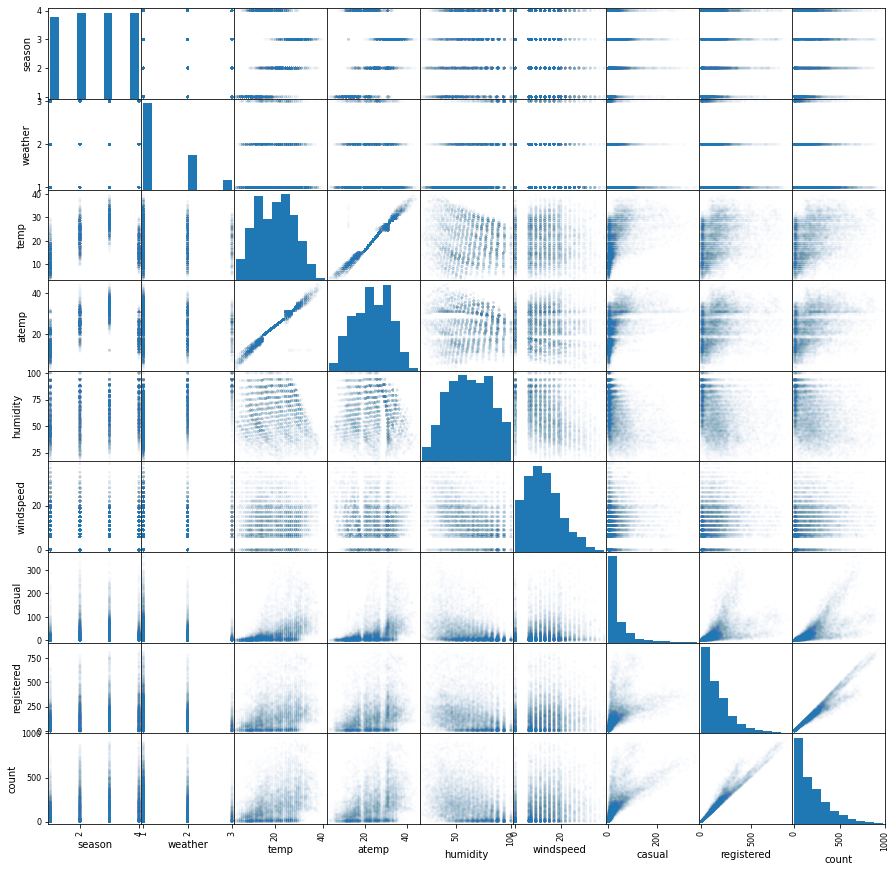

In [77]:
from pandas.plotting import scatter_matrix
scatter_matrix(data, alpha = .01, figsize = (15, 15))
pass

Теперь построим более красивые графики попарных зависимостей, где красный цвет - 1 тип погоды, синий - 2 и зеленый - 3 

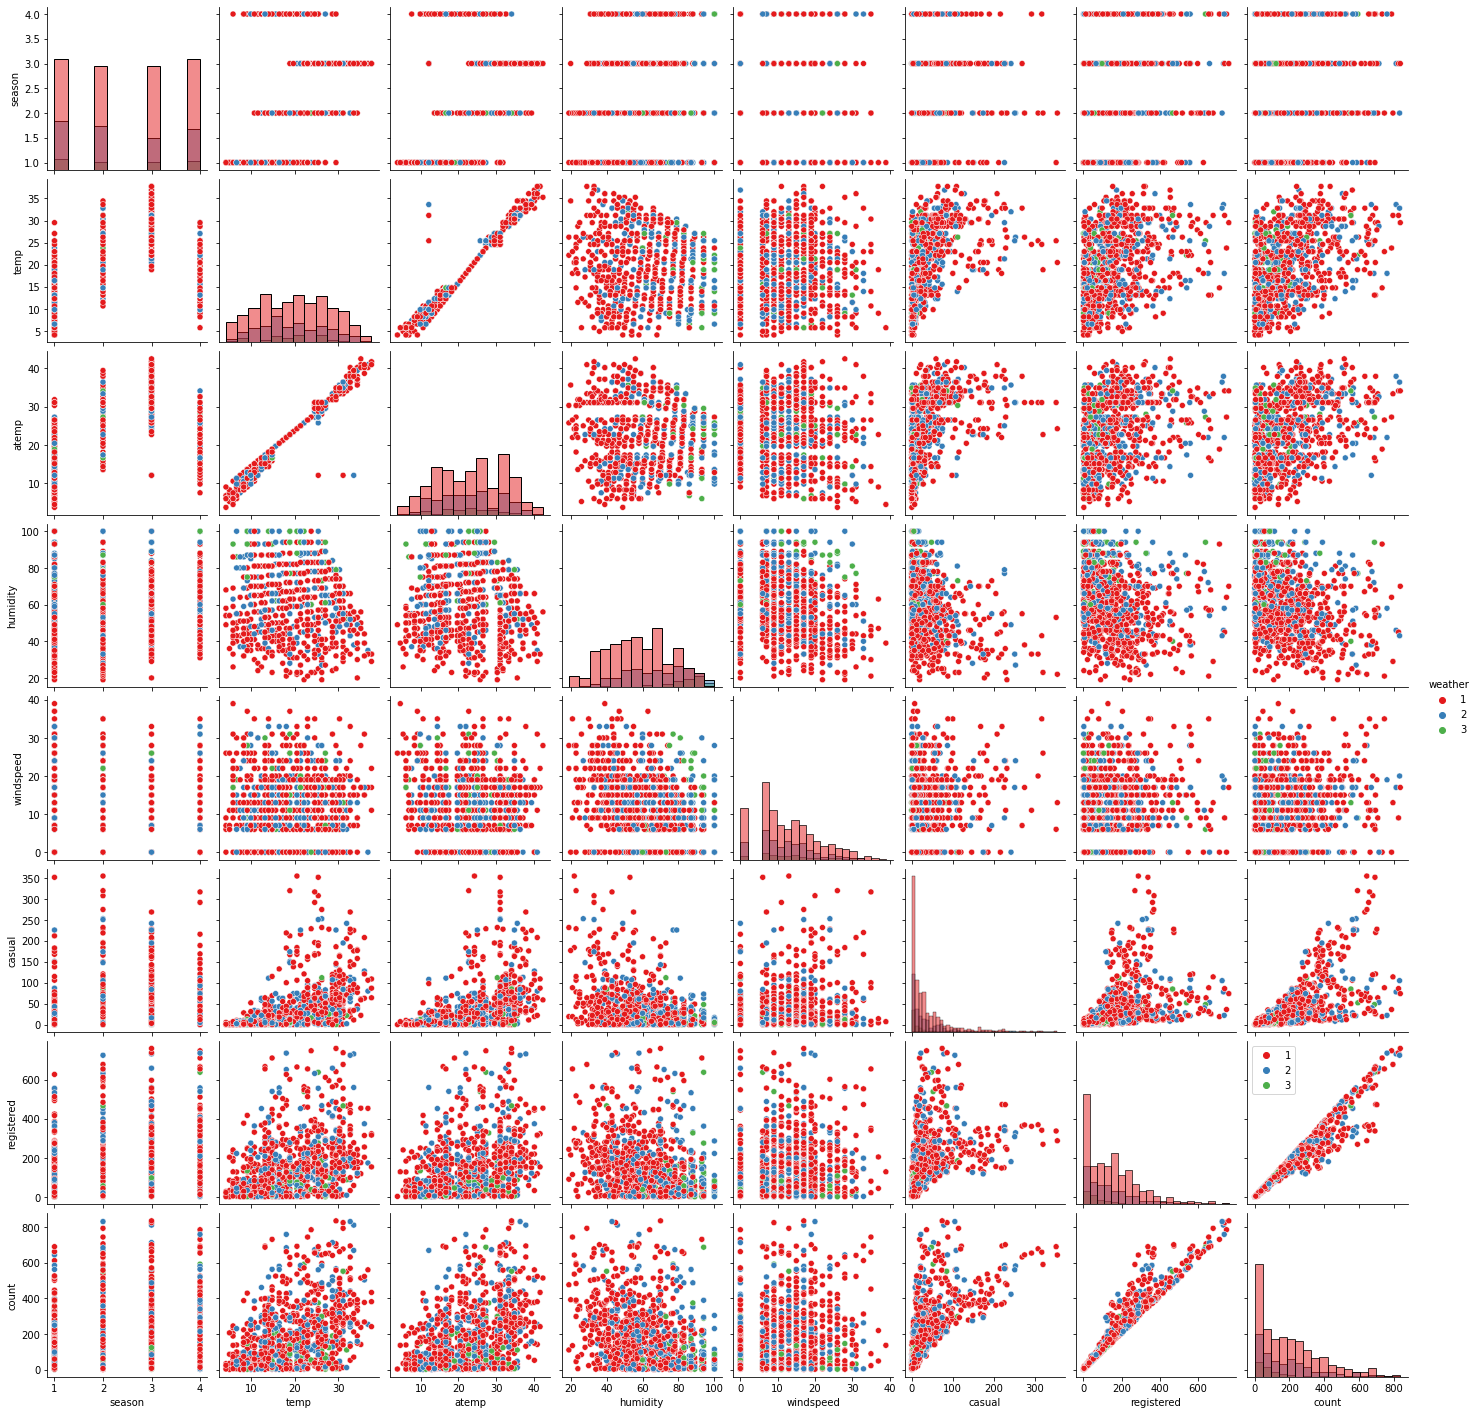

In [78]:
np.random.seed(25)
random_subset = np.random.choice(np.arange(data.shape[0]), size=1000, replace=False)
sns.pairplot(data.iloc[random_subset], hue='weather', palette='Set1', diag_kind='hist')
plt.legend()
pass

По графикам явно видна зависимость между температурой и "ощущением" температуры (что более, чем очевидно) и между числом зарегистрированных пользователей и общим числом аренд велосипедов (что также неудивительно). В остальных случаях сложно увидеть простые зависимости...

Посчитаем корреляционную матрицу:

In [79]:
corr_mat = data.corr()
corr_mat

,season,weather,temp,atemp,humidity,windspeed,casual,registered,count
season,1.000000,0.011907,0.251700,0.257947,0.175604,-0.137495,0.093179,0.159585,0.158790
weather,0.011907,1.000000,-0.056225,-0.056527,0.427818,-0.000020,-0.134906,-0.107239,-0.126622
temp,0.251700,-0.056225,1.000000,0.984838,-0.076220,-0.014122,0.466154,0.315651,0.391733
atemp,0.257947,-0.056527,0.984838,1.000000,-0.053763,-0.054291,0.461164,0.311669,0.387036
humidity,0.175604,0.427818,-0.076220,-0.053763,1.000000,-0.310985,-0.360956,-0.280652,-0.333554
windspeed,-0.137495,-0.000020,-0.014122,-0.054291,-0.310985,1.000000,0.096470,0.100166,0.110132
casual,0.093179,-0.134906,0.466154,0.461164,-0.360956,0.096470,1.000000,0.496663,0.689807
registered,0.159585,-0.107239,0.315651,0.311669,-0.280652,0.100166,0.496663,1.000000,0.970987
count,0.158790,-0.126622,0.391733,0.387036,-0.333554,0.110132,0.689807,0.970987,1.000000


Для более наглядного представления, посмотрим на визуальный образ этой матрицы:

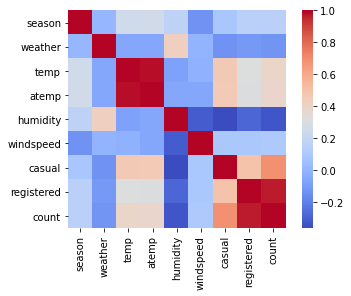

In [80]:
sns.heatmap(corr_mat, square=True, cmap='coolwarm')
pass

Посмотрим теперь между какими признаками корреляция больше 0.4

In [81]:
corr_mat > 0.4

,season,weather,temp,atemp,humidity,windspeed,casual,registered,count
season,True,False,False,False,False,False,False,False,False
weather,False,True,False,False,True,False,False,False,False
temp,False,False,True,True,False,False,True,False,False
atemp,False,False,True,True,False,False,True,False,False
humidity,False,True,False,False,True,False,False,False,False
windspeed,False,False,False,False,False,True,False,False,False
casual,False,False,True,True,False,False,True,True,True
registered,False,False,False,False,False,False,True,True,True
count,False,False,False,False,False,False,True,True,True


Убеждаемся, что линейных зависимостей очень мало

Посмотрим подробнее на зависимость количества аренд велосипедов от погоды:

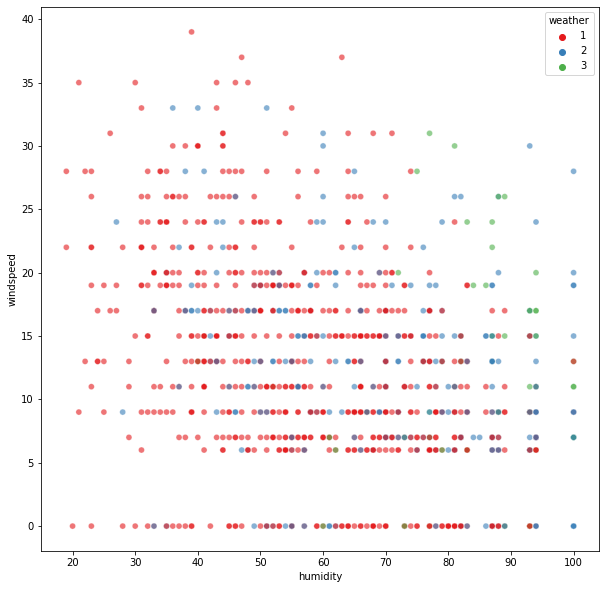

In [82]:
np.random.seed(25)
random_subset = np.random.choice(np.arange(data.shape[0]), size=1000, replace=False)
plt.figure(figsize = (10, 10))
sns.scatterplot(x='humidity', y='windspeed', hue='weather', data=data.iloc[random_subset], palette = 'Set1', alpha=0.6)
pass

Зависимость числа пользователей велосипедами от температуры воздуха:

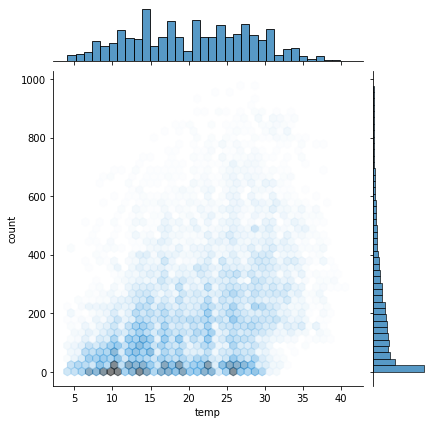

In [83]:
sns.jointplot(x='temp', y='count', data=data, kind='hex', alpha = 0.5);

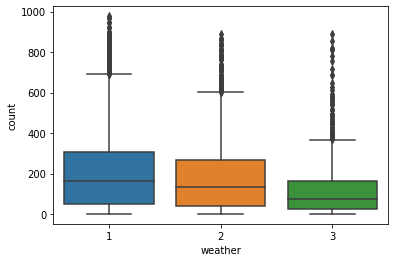

In [84]:
sns.boxplot(x="weather", y="count", data=data)
pass

По ящикам с усами заметно, что число аренд в хорошую погоду больше, чем в плохую, что вполне ожидаемо

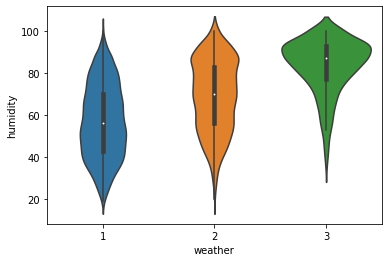

In [85]:
sns.violinplot(x="weather", y="humidity", data=data)
pass

По скрипичным графикам подтвеждается очевидный факт, что ясная погода менее влажная, тогда как пасмурная - более влажная

# 3. Обработка пропущенных значений

Убедимся, что пропущенных значений в нашей выборке нет:

In [86]:
data.isna().sum()

season        0
weather       0
temp          0
atemp         0
humidity      0
windspeed     0
casual        0
registered    0
count         0
dtype: int64

# 4. Обработка категориальных признаков

Категориальных признаков нет

# 5. Нормализация признаков

Перед применением алгоритмов машинного обучения количественные признаки полезно нормализовать.

Выполним стандартизацию всех признаков - линейное преобразование, приводящее все значения к нулевому среднему и единичному стандартному отклонению:

In [87]:
data_stand = (data - data.mean(axis = 0))/data.std(axis = 0)
data_stand.describe()

,season,weather,temp,atemp,humidity,windspeed,casual,registered,count
count,1.077200e+04,1.077200e+04,1.077200e+04,1.077200e+04,1.077200e+04,1.077200e+04,1.077200e+04,1.077200e+04,1.077200e+04
mean,-8.952899e-15,1.082849e-15,6.750727e-15,5.909711e-15,6.624235e-16,-4.897314e-14,2.062343e-16,-2.573745e-15,-6.511378e-16
std,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
min,-1.364979e+00,-6.600497e-01,-2.086025e+00,-2.453442e+00,-2.285409e+00,-1.596201e+00,-7.233349e-01,-1.032799e+00,-1.055283e+00
25%,-4.661187e-01,-6.600497e-01,-8.182628e-01,-8.367572e-01,-8.047320e-01,-7.124363e-01,-6.432711e-01,-7.881852e-01,-8.236655e-01
50%,4.327411e-01,-6.600497e-01,2.691189e-02,6.140104e-02,-1.151195e-02,4.447187e-02,-3.830640e-01,-2.460674e-01,-2.556499e-01
75%,1.331601e+00,9.277251e-01,7.664397e-01,8.700399e-01,8.345895e-01,5.493592e-01,2.574460e-01,4.414965e-01,5.108954e-01
max,1.331601e+00,2.515500e+00,2.668083e+00,2.576837e+00,1.997979e+00,3.326662e+00,6.622513e+00,4.824717e+00,4.327078e+00


# 6. Разбиение данных на обучающую и тестовую выборки

In [88]:
data['weather'].value_counts()

1    7122
2    2822
3     828
Name: weather, dtype: int64

Видим, что классы несбалансированны

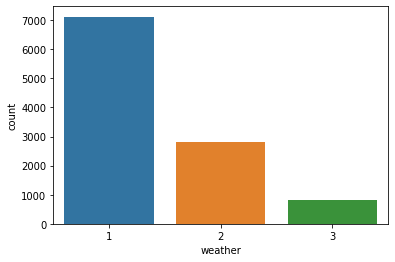

In [89]:
sns.countplot(x='weather', data=data)
pass

In [90]:
X = data_stand.drop(['weather'], axis=1)
y = data['weather']

Разобьем данные на обучающую и тестовую выборки в пропорции 3:1 (75% - обучающая выборка, 25% - тестовая):

In [91]:

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 25)

N_train, _ = X_train.shape 
N_test,  _ = X_test.shape 

N_train, N_test

(8079, 2693)

# 7. Запуск классификатора и вычисление ошибок



---
**Метод ближайших соседей** - для нового объекта алгоритм ищет в обучающей выборке k наиболее близких объектов и относит новый объект к тому классу, которому принадлежит большинство из них.


Обучаем модель:

In [92]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors = 15)
knn.fit(X_train, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=15, p=2,
                     weights='uniform')

После обучения модели, можно предсказывать значение целевого признака по оставшимся признакам для новых объектов с помощью метода predict. Нас интересует качество построенной модели, поэтому будем предсказывать значение выходного признака на тех данных, для которых оно известно: на обучающей и (что более важно) тестовой выборках:

In [93]:
y_train_predict = knn.predict(X_train)
y_test_predict = knn.predict(X_test)

err_train = np.mean(y_train != y_train_predict)
err_test  = np.mean(y_test  != y_test_predict)
print (err_train, err_test)

0.26166604777819036 0.28889714073523953


Ошибки предсказания на тренировочных и тестовых данных составляют 26.2% и 28.9% соответственно

Результаты, конечно, не слишком удовлетворительные. Попробуем найти наиболее оптимальное значение гиперпараметра.

Поиск оптимальных значений параметров можно осуществить с помощью класса GridSearchCV – поиск наилучшего набора параметров, доставляющих минимум ошибке перекрестного контроля (cross-validation). Будем рассматривать 5-кратный перекрестный контроль.

In [94]:
from sklearn.model_selection import GridSearchCV
k = [1, 3, 5, 7, 11, 19, 23, 29, 31, 37, 43, 61, 89, 101]
knn = KNeighborsClassifier()
grid = GridSearchCV(knn, cv=10, param_grid = {'n_neighbors': k})
grid.fit(X_train, y_train)

best_cv_err = 1 - grid.best_score_
best_n_neighbors = grid.best_estimator_.n_neighbors
print(best_cv_err, best_n_neighbors)

0.29310688039064137 23


Определено оптимальное значение k количества ближайших соседей равное 23 при ошибке 29.3%. Испытаем его:

In [95]:
knn = KNeighborsClassifier(n_neighbors = 23)
knn.fit(X_train, y_train)
y_test_predict = knn.predict(X_test)
err_test  = np.mean(y_test  != y_test_predict)
print (err_test)

0.2914964723356851


Имеем итоговую ошибку 29.1% для k=23



---


**Метод SVC - машина опорных векторов**

In [96]:
from sklearn.svm import SVC
svc = SVC(gamma='auto')
svc.fit(X_train, y_train)

err_train = np.mean(y_train != svc.predict(X_train))
err_test  = np.mean(y_test  != svc.predict(X_test))

print(err_train, err_test)

0.29372447085035275 0.29001113999257333


Ошибка на тестовой выборе 29.2%

# Выводы

По итогам проведённого исследования с использованием методов knn и SVC, получили минимальную ошибку чуть больше 29%.